# CNN Cancer Detection 

### Introduction:
This notebook is a binary image classification problem where I identify metastatic cancer in small image patches taken from larger digital pathology scans using CNN. There are 220k entries with an id and a label feature.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras.backend as K

from glob import glob
from skimage.io import imread
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

I was fortunate enough to use my GPU to help accelerate training via tensorflow

In [7]:
# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# EDA

In [16]:
train_labels_df = pd.read_csv("train_labels.csv")
train_labels_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [9]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Check for missing data and clean it out if any.

In [10]:
# Check for missing data
train_labels_df.isna().sum()

id       0
label    0
dtype: int64

In [12]:
print(f"Train pictures: {len(os.listdir('train/'))}")
print(f"Test pictures: {len(os.listdir('test/'))}")

Train pictures: 220027
Test pictures: 57460


# Visualizations

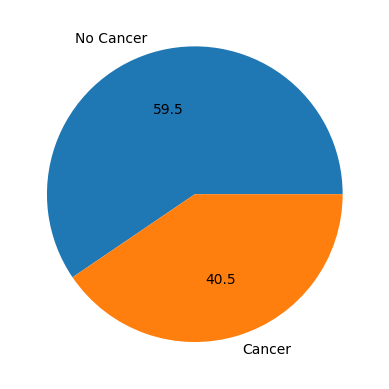

<Figure size 2000x2000 with 0 Axes>

In [13]:
labels_count = train_labels_df.label.value_counts()
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], autopct='%1.1f')
plt.figure(figsize=(20,20))
plt.show()

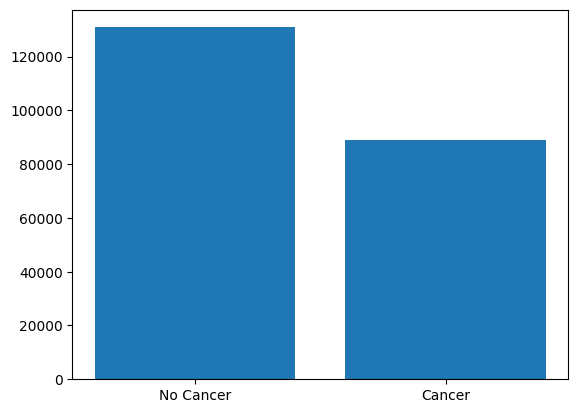

<Figure size 2000x2000 with 0 Axes>

In [14]:
labels_count = train_labels_df.label.value_counts()
plt.bar(x=["No Cancer", "Cancer"], height=labels_count)
plt.figure(figsize=(20,20))
plt.show()

I will be relying on the label stating the image has metastases cancer instead of looking at the images myself. Let's add the filepath of each image to the corresponding id for ease.

In [18]:
train_path = 'train/'
# Add image paths to the data frame for ease.
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[1].split(".")[0])
df_data = df.merge(train_labels_df, on = "id")

There's simply too many images for the kernel/GPU's memory so I purposely used a smaller size instead of the full training data.

In [19]:
# There's way too many images and kernel kept running out of memory so I took a
# smaller sample size of 5k per label type, so 10k in total.
SAMPLE_SIZE = 5000

df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 123)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 123)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))
print(df_data.head())
print(df_data.info())


                                                   path  \
5381  train/d2cd8b35850b65d1b249aa27cb45000a8e0ad6a4...   
3781  train/a5b7d32fd0fbc256c3604e1f967cf93197929cf7...   
3223  train/8198798e5d13a8fc750326ad74d168e713aad768...   
3320  train/00c37bfd185781b2495d84f4fd0c716fe7dcaabf...   
7261  train/118a34dfbc826fe64635114989fe75723d697f04...   

                                            id  label  
5381  d2cd8b35850b65d1b249aa27cb45000a8e0ad6a4      1  
3781  a5b7d32fd0fbc256c3604e1f967cf93197929cf7      0  
3223  8198798e5d13a8fc750326ad74d168e713aad768      0  
3320  00c37bfd185781b2495d84f4fd0c716fe7dcaabf      0  
7261  118a34dfbc826fe64635114989fe75723d697f04      1  
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 5381 to 2787
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10000 non-null  object
 1   id      10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object

Using imread to change and flatten the image to a numeric array and add it to the dataframe for ease

In [20]:
df_data['image'] = df_data['path'].map(imread)
df_data.sample(3)

path  \
2233  train/a63ed806ad35a8af327618e8d9d7b5b6fb77ae3b...   
2176  train/d9333418d15268ed03e333e92a1c69beb3526503...   
8343  train/3d1e7ea2953611ef02509b566e2a585d545d4047...   

                                            id  label  \
2233  a63ed806ad35a8af327618e8d9d7b5b6fb77ae3b      0   
2176  d9333418d15268ed03e333e92a1c69beb3526503      0   
8343  3d1e7ea2953611ef02509b566e2a585d545d4047      1   

                                                  image  
2233  [[[232, 159, 176], [218, 149, 167], [252, 188,...  
2176  [[[101, 37, 134], [245, 179, 255], [200, 134, ...  
8343  [[[185, 98, 195], [133, 51, 151], [163, 91, 19...

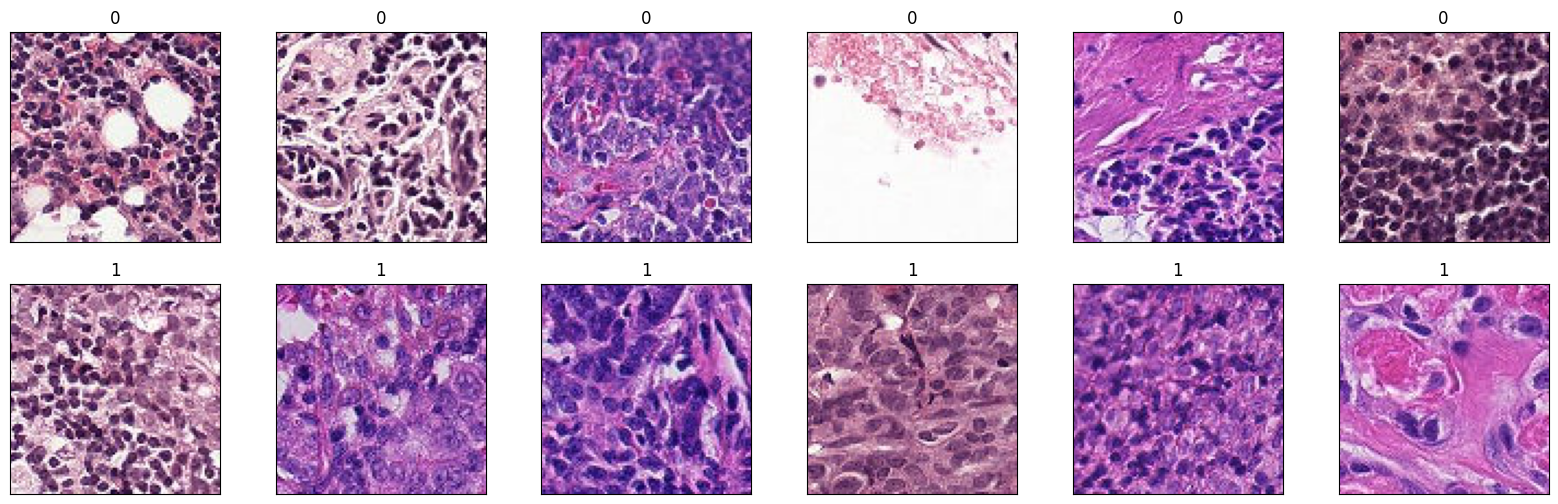

In [21]:
images = [(df_data['image'][0], df_data['label'][0]),
          (df_data['image'][1], df_data['label'][1]),
          (df_data['image'][2], df_data['label'][2]),
          (df_data['image'][3], df_data['label'][3]),
          (df_data['image'][4], df_data['label'][4]),
          (df_data['image'][5], df_data['label'][5]),
          (df_data['image'][7500], df_data['label'][7500]),
          (df_data['image'][7501], df_data['label'][7501]),
          (df_data['image'][7502], df_data['label'][7502]),
          (df_data['image'][7503], df_data['label'][7503]),
          (df_data['image'][7504], df_data['label'][7504]),
          (df_data['image'][7505], df_data['label'][7505])]

# show 12 images
fig = plt.figure(figsize=(20, 6))
for i in range(len(images)):
    ax = fig.add_subplot(2, 12 // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i][0])
    ax.set_title(images[i][1])

I can't really tell what the differences between cancer and not cancer so starting our model we'll create our set of inputs. We can do this by using np.stack to create a 4-rank tensor: 10,000 observations, 5,000 cancer, 5,000 not cancer. Each one is a 96x96x3 image.

In [22]:
images = np.stack(list(df_data.image), axis = 0)
images.shape

(10000, 96, 96, 3)

# Modeling


In [23]:
# Train on 80% of our sample size
train_size = 0.8

# encode them
encoder = LabelBinarizer()
y = encoder.fit_transform(df_data.label)
x = images

train_tensors, test_tensors, train_targets, test_targets = train_test_split(x, y, train_size=train_size, random_state=123)

valid_size = int(0.5 * len(test_tensors))
# Use half for the validation_data parameter
valid_tensors = test_tensors[:valid_size]
valid_targets = test_targets[:valid_size]
test_tensors = test_tensors[valid_size:]
test_targets = test_targets[valid_size:]

### Hyperparameter Tuning

Some minor hyperparameter tuning I did was the early stopping of the model per epoch. Waiting a bit longer sometimes gets us a better result so I ended up with 5 seconds for patience.

### Model Architecture

Ended up using tensorflow with CUDA and Keras with a CNN.

CNN model layers:
- Sequential input
- 3 x [Conv2D * 3 -> Dropout -> MaxPool2d] x [filters=16, 32, 64]
- Conv2d(filters=128) * 2 
- Conv2d(filters=256)
- Flatten
- Dense out

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(filepath='weights.hdf5.keras',
                               verbose=1, save_best_only=True)
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='elu'))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

/home/basilp/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744587086.828138  209363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 25
model.fit(
    train_tensors,
    train_targets,
    validation_data=(valid_tensors, valid_targets),
    epochs=epochs,
    batch_size=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/25
158/160 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8470 - loss: 0.3547
Epoch 1: val_loss did not improve from 0.40181
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8469 - loss: 0.3549 - val_accuracy: 0.8040 - val_loss: 0.4340
Epoch 2/25
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8648 - loss: 0.3223
Epoch 2: val_loss did not improve from 0.40181
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8647 - loss: 0.3225 - val_accuracy: 0.7900 - val_loss: 0.4355
Epoch 3/25
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8493 - loss: 0.3390
Epoch 3: val_loss did not improve from 0.40181
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8493 - loss: 0.3389 - val_accuracy: 0.8040 - val_loss: 0.4304
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8627 - loss: 0.3206
Epoch 4: val_loss did not improve from 0.40181
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8627 - loss: 0.3206 - val_accuracy: 0.8120 - val_loss: 0.4133

### Hyperparameter Tuning: Batch size
Doubling the batch size from 50 to 100 seems to get a higher accuracy by 2%.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 25
model.fit(
    train_tensors,
    train_targets,
    validation_data=(valid_tensors, valid_targets),
    epochs=epochs,
    batch_size=100,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/25
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8592 - loss: 0.3430
Epoch 1: val_loss did not improve from 0.42746
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8590 - loss: 0.3431 - val_accuracy: 0.7900 - val_loss: 0.4577
Epoch 2/25
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8598 - loss: 0.3205
Epoch 2: val_loss did not improve from 0.42746
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8601 - loss: 0.3201 - val_accuracy: 0.8080 - val_loss: 0.4323
Epoch 3/25
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8730 - loss: 0.2991
Epoch 3: val_loss improved from 0.42746 to 0.42327, saving model to weights.hdf5.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8728 - loss: 0.2996 - val_accuracy: 0.8020 - val_loss: 0.4233
Epoch 4/25
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8784 - loss: 0.2855
Epoch 4: val_loss improved from 0.42327 to 0.40181, saving model to weights.hdf5.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - ac

Run our trained model against the training data we sampled (10k) and see how we do. 

In [39]:
model.load_weights('weights.hdf5.keras')

cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

train_accuracy = 100 * np.sum(np.round(cancer_predictions).astype('int32')==test_targets.flatten())/len(cancer_predictions)
print(f'Train accuracy: {train_accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

Get the actual ROC accuracy score

In [37]:
score = roc_auc_score(np.round(cancer_predictions).astype("int32"), test_targets)
print(f"roc score: {score}")


roc score: 0.8392339233923393


### Training Conclusion

Our model was able to train up to 89.19% accuracy and then the ROC score ended up being 83.9% which isn't that bad for small portion we did 10k out of 220k.

# Running our model against the Test Data
For our final part, we need to run our model against the test_data to submit it to Kaggle.

Setting up the test dataframe similar to what we did earlier for our training dataframe. 

In [ ]:
base_tile_dir = "test/"
test_df = pd.DataFrame({"path": glob(os.path.join(base_tile_dir,"*.tif"))})
test_df["id"] = test_df.path.map(lambda x: x.split("/")[1].split(".")[0])

Using imread to change the image to a numeric array and adding it to the dataframe for ease.

In [ ]:
test_df["image"] = test_df["path"].map(imread)

Creating our set of inputs for a 4-stack tensor like we did for our training dataset

In [ ]:
test_data = np.stack(test_df.image, axis = 0)
test_data.shape

(57458, 96, 96, 3)

Run our trained model against the test data. This took about 74.5 minutes with my NVIDIA 3090 across the 57k images.

In [ ]:
submission_labels =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_data]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Package it all up for the Kaggle submission

In [ ]:
submission_predictions = np.array(submission_labels)
test_df["label"] = submission_predictions
submission = test_df[["id", "label"]]
submission.head()

id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.710713
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.730420
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.860881
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.695904
4  000270442cc15af719583a8172c87cd2bd9c7746  0.128247

In [40]:
submission.to_csv("submission.csv", index=False, header=True)

# Conclusion
In order to save time and efficiency, using a small set 10k images to train our deep learning model using Keras and tensorflow, I was able to predict at a 0.8927 public score accuracy of cancer results on Kaggle. This is insanely effective considering it took less than 2 minutes to train and only 75 minutes to run it against the test results. 

![results](submission_results.png)